![alt text](./img/header.png)

# SWI Model of steady interface flow towards the coast

## Teacher's solution
Mark Bakker, TU Delft, The Netherlands

In [109]:
%matplotlib inline
import flopy.modflow as mfl
import flopy.utils as fut
import flopy.plot as fp
import numpy as np
import matplotlib.pyplot as plt
from semi_interface import SemiCoast

### Question: Try to simulate the steady interface position of the analytic solution below

toe of interface at: -966.980727511054
tip of interface at: 132.07708995578503


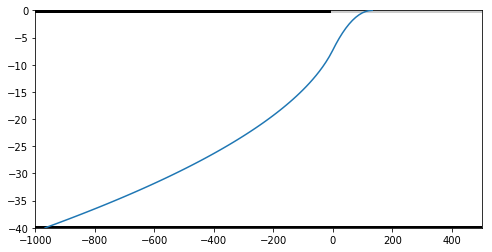

In [111]:
sc = SemiCoast(k=20, H=40, c=20.0, grad=0.0005, rhof=1000, rhos=1025, 
               ztop=0, sealevel=0.0)
print('toe of interface at:', sc.toe())
print('tip of interface at:', sc.tip())
sc.plot(xmin=-1000, xmax=500)

In [113]:
nlay = 1
nrow = 1
ncol = 200
delr = 10.
delc = 1.
k = 20.0
H = 40.0
grad = 0.0005
Q0 = k * H * grad
csea = 20.0
nsea = 50
nper = 1
perlen = 100000
nstp = 400
#
modelname = 'coast'
ml = mfl.Modflow(modelname, version='mf2005', exe_name=config.mfexe, model_ws='./data')
#
discret = mfl.ModflowDis(ml, nlay=nlay, nrow=nrow, ncol=ncol, 
                         delr=delr, delc=delc,
                         top=0, botm=-H, steady=True, 
                         nper=nper, perlen=perlen, nstp=nstp)
#
ibound = np.ones((nlay, nrow, ncol))
#
bas = mfl.ModflowBas(ml, ibound=ibound, strt=0.0)
#
lpf = mfl.ModflowLpf(ml, hk=k, laytyp=0, layavg=0)
#
lrcq = np.array([0, 0, 0, Q0])
wel = mfl.ModflowWel(ml, stress_period_data={0: lrcq})
#
lrchc = np.zeros((nsea, 5))
lrchc[:, 0] = 0
lrchc[:, 1] = 0
lrchc[:, 2] = np.arange(ncol - nsea, ncol)
lrchc[:, 3] = 0.
lrchc[:, 4] = delr * delc / csea
ghb = mfl.ModflowGhb(ml, stress_period_data={0:lrchc})
#
pcg = mfl.ModflowPcg(ml)
#
oc = mfl.ModflowOc(ml, save_every=1)
#
z0 = np.zeros((1, ncol))
z0[0, :100] = -H
z0[0, 100:150] = np.linspace(-H, 0, 50)
isource = np.ones((1, ncol), np.int)
isource[0, ncol - nsea:] = -2
swi = mfl.ModflowSwi2(ml, nsrf=1, istrat=1, 
                      toeslope=0.01, tipslope=0.01, nu=[0, 0.025],
                      zeta=[z0], ssz=0.2, isource=isource, 
                      nsolver=1, iswizt=55)
ml.write_input()
ml.run_model(silent=True)

(True, [])

In [114]:
# read model heads
hfile = fut.HeadFile('./data/' + modelname + '.hds')
head = hfile.get_alldata()
# read model zeta
zfile = fut.CellBudgetFile('./data/' + modelname + '.zta')
kstpkper = zfile.get_kstpkper()
zeta = []
for kk in kstpkper:
    zeta.append(zfile.get_data(kstpkper=kk, text='ZETASRF  1')[0])
zeta = np.array(zeta)
# create array of x-coordinates
x = np.cumsum(delr * np.ones(ncol)) - 1500

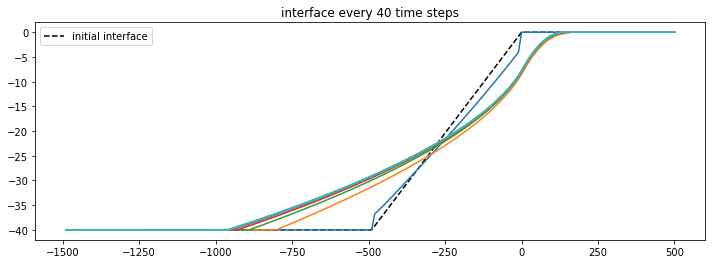

In [116]:
plt.figure(figsize=(12, 4))
plt.title('interface every 40 time steps')
plt.plot(x, z0[0], 'k--', label='initial interface')
for i in range(0, 400, 40):
    plt.plot(x, zeta[i, 0, 0])
plt.legend();